In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from datetime import datetime
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, UpSampling2D, Dropout,BatchNormalization,GlobalAveragePooling2D
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from PIL import Image

In [ ]:
def plot_acc_loss(result):
  # function to plot the accuracy and loss graphs
  acc = result.history['accuracy']
  val_acc = result.history['val_accuracy']
  loss = result.history['loss']
  val_loss = result.history['val_loss']

  plt.figure(figsize=(20, 10))
  plt.subplot(1, 2, 1)
  plt.title("Training and Validation Accuracy")
  plt.plot(acc,color = 'green',label = 'Training Acuracy')
  plt.plot(val_acc,color = 'red',label = 'Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.subplot(1, 2, 2)
  plt.title('Training and Validation Loss')
  plt.plot(loss,color = 'blue',label = 'Training Loss')
  plt.plot(val_loss,color = 'purple',label = 'Validation Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(loc='upper right')
  plt.show()

In [ ]:
import imageio
import six
from keras.models import Model
from keras.layers import ( Input, Activation, Dense, Flatten )
import tensorflow as tf
from keras.layers import ( Conv2D, MaxPooling2D, AveragePooling2D )
from keras.layers import add
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras import backend as K

from keras.preprocessing.image import ImageDataGenerator
from keras import utils as np_utils
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping

import numpy as np
import time
import scipy.ndimage as nd

from tensorflow.keras.applications.vgg19 import preprocess_input

In [ ]:
from google.colab import drive

drive.mount( '/content/drive', force_remount=True )

Mounted at /content/drive


In [ ]:
! git clone https://github.com/seshuad/IMagenet
! ls 'IMagenet/tiny-imagenet-200/'

Cloning into 'IMagenet'...
remote: Enumerating objects: 120594, done.
remote: Total 120594 (delta 0), reused 0 (delta 0), pack-reused 120594
Receiving objects: 100% (120594/120594), 212.68 MiB | 44.66 MiB/s, done.
Resolving deltas: 100% (1115/1115), done.
Updating files: 100% (120206/120206), done.
test  train  val  wnids.txt  words.txt


In [ ]:
import time
import numpy as np
import imageio
from PIL import Image

path = 'IMagenet/tiny-imagenet-200/'

def get_id_dictionary():
    id_dict = {}
    for i, line in enumerate(open(path + 'wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i
    return id_dict

def get_class_to_id_dict():
    id_dict = get_id_dictionary()
    all_classes = {}
    result = {}
    for i, line in enumerate(open(path + 'words.txt', 'r')):
        n_id, word = line.split('\t')[:2]
        all_classes[n_id] = word
    for key, value in id_dict.items():
        result[value] = (key, all_classes[key])
    return result

def resize_image(image_path, target_size=(32, 32)):
    with Image.open(image_path) as img:
        # Convert image to RGB
        img = img.convert('RGB')
        # Resize image
        img = img.resize(target_size, Image.Resampling.LANCZOS)  # Updated to use Resampling.LANCZOS
        return np.array(img)

def get_data(id_dict):
    print('starting loading data')
    train_data, test_data = [], []
    train_labels, test_labels = [], []
    t = time.time()

    # Load and resize train images
    for key, value in id_dict.items():
        images = [resize_image(path + 'train/{}/images/{}_{}.JPEG'.format(key, key, str(i))) for i in range(500)]
        train_data.extend(images)
        train_labels_ = np.zeros((500, 200))
        train_labels_[:, value] = 1
        train_labels.extend(train_labels_)

    # Load and resize validation images
    for line in open(path + 'val/val_annotations.txt'):
        img_name, class_id = line.split('\t')[:2]
        image = resize_image(path + 'val/images/{}'.format(img_name))
        test_data.append(image)
        test_labels_ = np.zeros((1, 200))
        test_labels_[0, id_dict[class_id]] = 1
        test_labels.extend(test_labels_)

    print('finished loading data, in {} seconds'.format(time.time() - t))
    return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels)

train_data, train_labels, test_data, test_labels = get_data(get_id_dictionary())

print("train data shape: ", train_data.shape)
print("train label shape: ", train_labels.shape)
print("test data shape: ", test_data.shape)
print("test_labels.shape: ", test_labels.shape)


starting loading data
finished loading data, in 32.2866096496582 seconds
train data shape:  (100000, 32, 32, 3)
train label shape:  (100000, 200)
test data shape:  (10000, 32, 32, 3)
test_labels.shape:  (10000, 200)


In [ ]:
import keras
inputs = keras.Input(shape=(64,64,3))

In [ ]:
def shuffle_data(train_data, train_labels ):
    size = len(train_data)
    train_idx = np.arange(size)
    np.random.shuffle(train_idx)

    return train_data[train_idx], train_labels[train_idx]

train_data, train_labels = shuffle_data(train_data, train_labels)

In [ ]:
train_data = train_data * 1.0/255
test_data = test_data * 1.0/255

In [ ]:
train_datagen = ImageDataGenerator(
        rotation_range = 10,
        zoom_range = 0.1,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        shear_range = 0.1,
        horizontal_flip = True,
        vertical_flip = False
        )
train_datagen.fit(train_data)

In [ ]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.6,
    min_lr=1e-6)

In [ ]:
reconstructed_model = tf.keras.models.load_model('model.keras')

In [ ]:
reconstructed_model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_173 (Conv2D)         (None, 32, 32, 128)       3584      
                                                                 
 p_re_lu_30 (PReLU)          (None, 32, 32, 128)       131072    
                                                                 
 batch_normalization_110 (B  (None, 32, 32, 128)       512       
 atchNormalization)                                              
                                                                 
 conv2d_174 (Conv2D)         (None, 32, 32, 128)       409728    
                                                                 
 p_re_lu_31 (PReLU)          (None, 32, 32, 128)       131072    
                                                                 
 batch_normalization_111 (B  (None, 32, 32, 128)       512       
 atchNormalization)                                  

In [ ]:
new_model = tf.keras.Sequential()
for layer in reconstructed_model.layers[:-1]:
    layer.trainable = False
    new_model.add(layer)

new_model.add(tf.keras.layers.Dense(200, activation='softmax'))

In [ ]:
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
new_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_173 (Conv2D)         (None, 32, 32, 128)       3584      
                                                                 
 p_re_lu_30 (PReLU)          (None, 32, 32, 128)       131072    
                                                                 
 batch_normalization_110 (B  (None, 32, 32, 128)       512       
 atchNormalization)                                              
                                                                 
 conv2d_174 (Conv2D)         (None, 32, 32, 128)       409728    
                                                                 
 p_re_lu_31 (PReLU)          (None, 32, 32, 128)       131072    
                                                                 
 batch_normalization_111 (B  (None, 32, 32, 128)       512       
 atchNormalization)                                   

In [ ]:
x_train,x_val,y_train,y_val = train_test_split(train_data, train_labels, test_size = 0.2)

In [ ]:
history = new_model.fit(
    train_datagen.flow(x_train, y_train, batch_size = 64),
    validation_data = (x_val, y_val),
    epochs = 20,
    verbose = 1
)

Epoch 1/20
1250/1250 [==============================] - 50s 37ms/step - loss: 4.4448 - accuracy: 0.0860 - val_loss: 4.0160 - val_accuracy: 0.1407
Epoch 2/20
1250/1250 [==============================] - 45s 36ms/step - loss: 4.1499 - accuracy: 0.1196 - val_loss: 3.9516 - val_accuracy: 0.1505
Epoch 3/20
1250/1250 [==============================] - 45s 36ms/step - loss: 4.0949 - accuracy: 0.1283 - val_loss: 3.9089 - val_accuracy: 0.1547
Epoch 4/20
1250/1250 [==============================] - 45s 36ms/step - loss: 4.0655 - accuracy: 0.1308 - val_loss: 3.9021 - val_accuracy: 0.1564
Epoch 5/20
1250/1250 [==============================] - 45s 36ms/step - loss: 4.0583 - accuracy: 0.1324 - val_loss: 3.8875 - val_accuracy: 0.1548
Epoch 6/20
1250/1250 [==============================] - 45s 36ms/step - loss: 4.0461 - accuracy: 0.1330 - val_loss: 3.8846 - val_accuracy: 0.1597
Epoch 7/20
1250/1250 [==============================] - 45s 36ms/step - loss: 4.0352 - accuracy: 0.1355 - val_loss: 3.8768 -

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
resnet_model = ResNet50(
    include_top = False,
    weights = 'imagenet',
    input_shape = (64,64,3)
)

for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model=tf.keras.models.Sequential()
model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(.25))
model.add(Dense(256, activation='elu'))
model.add(BatchNormalization())
model.add(Dense(200, activation='softmax'))

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

In [ ]:
model.compile(
    optimizer = optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
x_train,x_val,y_train,y_val = train_test_split(train_data, train_labels, test_size = 0.2)

In [ ]:
result=model.fit(
    train_datagen.flow(x_train, y_train, batch_size = 64),
    validation_data = (x_val, y_val),
    epochs = 20,
    verbose = 1,
    callbacks = [learning_rate_reduction]
)

Epoch 1/20
1250/1250 [==============================] - 122s 85ms/step - loss: 4.7827 - accuracy: 0.0803 - val_loss: 3.9301 - val_accuracy: 0.1979 - lr: 0.0010
Epoch 2/20
1250/1250 [==============================] - 102s 81ms/step - loss: 3.7729 - accuracy: 0.2026 - val_loss: 3.3193 - val_accuracy: 0.2767 - lr: 0.0010
Epoch 3/20
1250/1250 [==============================] - 102s 81ms/step - loss: 3.3643 - accuracy: 0.2614 - val_loss: 3.0420 - val_accuracy: 0.3203 - lr: 0.0010
Epoch 4/20
1250/1250 [==============================] - 102s 82ms/step - loss: 3.1218 - accuracy: 0.2995 - val_loss: 2.8769 - val_accuracy: 0.3471 - lr: 0.0010
Epoch 5/20
1250/1250 [==============================] - 102s 82ms/step - loss: 2.9620 - accuracy: 0.3258 - val_loss: 2.7594 - val_accuracy: 0.3672 - lr: 0.0010
Epoch 6/20
1250/1250 [==============================] - 102s 82ms/step - loss: 2.8388 - accuracy: 0.3458 - val_loss: 2.6712 - val_accuracy: 0.3812 - lr: 0.0010
Epoch 7/20
1250/1250 [==================

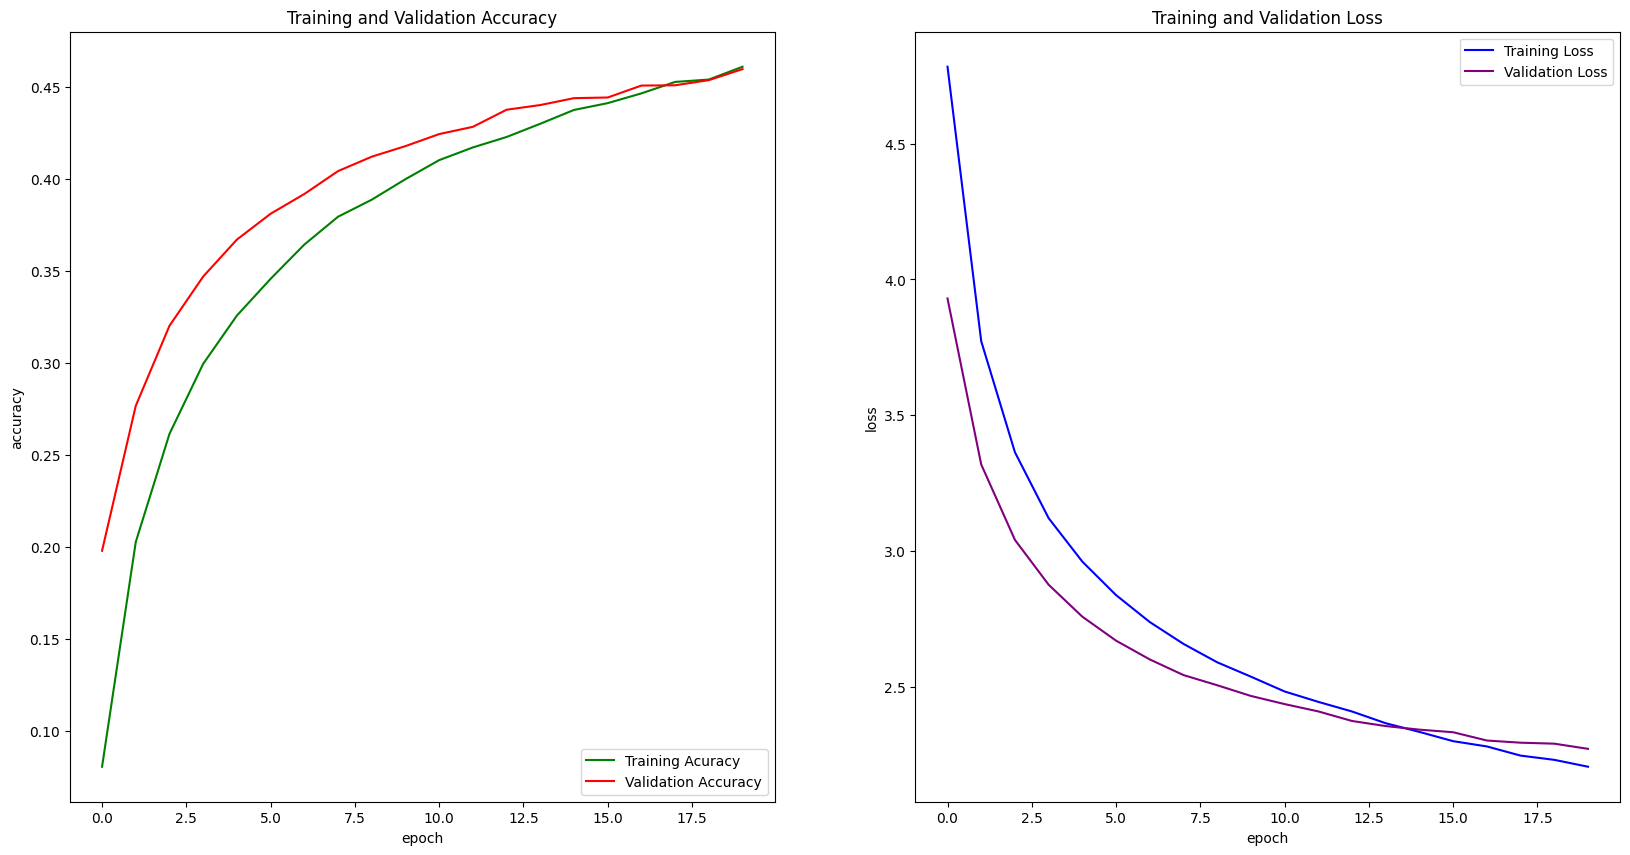

In [ ]:
plot_acc_loss(result)

In [ ]:
print("Testing Accuracy: ", accuracy_score(y_true,y_pred))

NameError: name 'y_true' is not defined